## Predicting Patient Readmission to the Hospital

Hospital readmission is very expensive, and it is an emerging indicator of quality of health care. On average, Medicare spends double the amount for an episode with one readmission. Moreover, diabetes is a chronic disease affecting people of all ages and is prevalent in a large amount of people all over the world. Thus, examining the historical patterns of diabetic’s care is
very essential which might lead to improvements in patient safety and prevent future readmissions. This not only improves the quality of care but also reduces the medical expenses on readmission. There are a few studies on readmission rates among individuals with diabetes. Different tools and models were built to predict the risk of all-cause readmission within 30 days
among hospitalized patients with diabetes.

#### Abstract:
In order to provide a valid assessment and to find future directions which might lead to improvements in patient safety, we must determine all the contributing factors for predicting readmission of diabetes patients. We will implement a ML Model to see whether a patient will readmit within 30 Days.

#### Attribute Information:
* Patient ID: Unique identifier of a patient
* Race Values: Caucasian, Asian, African American, Hispanic, and other
* Gender Values: male, female, and unknown/invalid
* Age Grouped in 10-year intervals: 0, 10), 10, 20), …, 90, 100)
* Weight: Weight in pounds
* Admission type: Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available
* Admission source: Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital
* Discharge :Date: The date on which a patient was discharged
* Payer code Integer identifier corresponding to 23 distinct values, for example, Blue Cross/Blue Shield, Medicare, and self-pay Medical
* Medical specialty: Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family/general practice, and surgeon
* Number of lab procedures: Number of lab tests performed during the encounter
* Number of procedures: Numeric Number of procedures (other than lab tests) performed during the encounter
* Number of medications: Number of distinct generic names administered during the encounter
* Number of diagnoses: Number of diagnoses entered to the system 0%
* Glucose serum test result: Indicates the range of the result or if the test was not taken. Values: “>200,” “>300,” “normal,” and “none” if not measured
* A1c test result: Indicates the range of the result or if the test was not taken. Values: “>8” if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured.
* Change of medications: Indicates if there was a change in diabetic medications (either dosage or generic name). Values: “change” and “no change”
* Diabetes medications: Indicates if there was any diabetic medication prescribed. Values: “yes” and “no”
* 24 features for medications For the generic names: metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiride- pioglitazone, metformin-rosiglitazone, and metformin- pioglitazone, the feature indicates whether the drug was prescribed or there was a change in the dosage. Values: “up” if the dosage was increased during the encounter, “down” if the dosage was decreased, “steady” if the dosage did not change, and “no” if the drug was not prescribed
* Target: Indicates if a patient is readmitted or not. We need to predict this value

In [1]:
import pandas as pd
import re
import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_columns', None)

In [2]:
patient_data = pd.read_csv("D:\\Data Science\\patient readmission\\Patientdata.csv",sep=",")
diagnosis_data = pd.read_csv("D:\\Data Science\\patient readmission\\Diagnosisdata.csv",sep=",")
hospital_data = pd.read_csv("D:\\Data Science\\patient readmission\\Hospitaldata.csv",sep=",")

In [3]:
print("Shape of patient_data - ", patient_data.shape,"\n",
     "Shape of diagnosis_data - ", diagnosis_data.shape,"\n",
     "Shape of hospital_data - ", hospital_data.shape,"\n")

Shape of patient_data -  (31513, 7) 
 Shape of diagnosis_data -  (31513, 29) 
 Shape of hospital_data -  (31513, 9) 



#### Splitting the train and test data

In [4]:
is_train = patient_data["istrain"] == 1
patient_data_train = patient_data[is_train]
patient_data_test = patient_data[~is_train]

is_train = diagnosis_data["istrain"] == 1
diagnosis_data_train = diagnosis_data[is_train]
diagnosis_data_test = diagnosis_data[~is_train]

is_train = hospital_data["istrain"] == 1
hospital_data_train = hospital_data[is_train]
hospital_data_test = hospital_data[~is_train]

In [5]:
patient_data_test.shape

(7257, 7)

In [6]:
patient_data_join = patient_data_test.merge(patient_data_train,on=["patientID"])

In [7]:
a = [1,2,3]
b = [1,2,3,4]
[i for i in b if i not in a]
for i in b:
    if i not in a:
        print(i)

4


In [8]:
patient_data_test[~patient_data_test.patientID.isin(list(patient_data_train.patientID))]

,patientID,race,gender,age,weight,Target,istrain


In [9]:
patient_data_train.shape

(24256, 7)

In [10]:
# Drop istrain column as it has a constant value
patient_data_train = patient_data_train.drop(["istrain"],axis=1)
patient_data_test = patient_data_test.drop(["istrain"],axis=1)
diagnosis_data_train = diagnosis_data_train.drop(["istrain"],axis=1)
diagnosis_data_test = diagnosis_data_test.drop(["istrain"],axis=1)
hospital_data_train = hospital_data_train.drop(["istrain"],axis=1)
hospital_data_test = hospital_data_test.drop(["istrain"],axis=1)

#### EDA

In [11]:
print("Shape of patient_data_train - ", patient_data_train.shape,"\n",
     "Shape of diagnosis_data_train - ", diagnosis_data_train.shape,"\n",
     "Shape of hospital_data_train - ", hospital_data_train.shape,"\n")

Shape of patient_data_train -  (24256, 6) 
 Shape of diagnosis_data_train -  (24256, 28) 
 Shape of hospital_data_train -  (24256, 8) 



In [12]:
patient_data_train.head()

,patientID,race,gender,age,weight,Target
0,PT456611,type3,Female,[90-100),NaN,No
1,PT956824,type1,Male,[50-60),NaN,Yes
2,PT453330,type3,Female,[80-90),NaN,No
3,PT677563,type3,Female,[50-60),NaN,No
4,PT102924,type3,Male,[60-70),NaN,Yes


In [13]:
diagnosis_data_train.head()

,patientID,num_procedures,num_medications,num_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide.metformin,glipizide.metformin,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed
0,PT456611,0,11,9,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,Steady,No,No,No,No,Ch,Yes
1,PT956824,1,6,6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
2,PT453330,2,27,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
3,PT677563,3,10,5,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Yes
4,PT102924,6,12,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No


In [14]:
hospital_data_train.head()

,AdmissionID,patientID,Admission_date,Discharge_date,admission_type_id,admission_source_id,payer_code,medical_specialty
0,AD988251,PT456611,2015-05-04,2015-05-07,1,1,PC8,NaN
1,AD725487,PT956824,2014-02-20,2014-02-23,1,7,PC1,Oncology
2,AD492141,PT453330,2015-06-01,2015-06-04,1,7,PC8,NaN
3,AD561393,PT677563,2015-12-18,2015-12-20,2,1,NaN,Cardiology
4,AD619257,PT102924,2015-08-19,2015-08-20,3,1,NaN,NaN


In [15]:
patient_data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24256 entries, 0 to 24255
Data columns (total 6 columns):
patientID    24256 non-null object
race         24256 non-null object
gender       24256 non-null object
age          24256 non-null object
weight       719 non-null object
Target       24256 non-null object
dtypes: object(6)
memory usage: 1.3+ MB


In [16]:
diagnosis_data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24256 entries, 0 to 24255
Data columns (total 28 columns):
patientID                  24256 non-null object
num_procedures             24256 non-null int64
num_medications            24256 non-null int64
num_diagnoses              24256 non-null int64
max_glu_serum              24256 non-null object
A1Cresult                  24256 non-null object
metformin                  24256 non-null object
repaglinide                24256 non-null object
nateglinide                24256 non-null object
chlorpropamide             24256 non-null object
glimepiride                24256 non-null object
acetohexamide              24256 non-null object
glipizide                  24256 non-null object
glyburide                  24256 non-null object
tolbutamide                24256 non-null object
pioglitazone               24256 non-null object
rosiglitazone              24256 non-null object
acarbose                   24256 non-null object
miglitol    

In [17]:
hospital_data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24256 entries, 0 to 24255
Data columns (total 8 columns):
AdmissionID            24256 non-null object
patientID              24256 non-null object
Admission_date         24256 non-null object
Discharge_date         24256 non-null object
admission_type_id      24256 non-null int64
admission_source_id    24256 non-null int64
payer_code             14045 non-null object
medical_specialty      12779 non-null object
dtypes: int64(2), object(6)
memory usage: 1.7+ MB


In [18]:
patient_hospital_data_train = diagnosis_data_train.merge(hospital_data_train, on=["patientID"])
train_data = patient_hospital_data_train.merge(patient_data_train, on=["patientID"])

patient_hospital_data_test = diagnosis_data_test.merge(hospital_data_test, on=["patientID"])
test_data = patient_hospital_data_test.merge(patient_data_test, on=["patientID"])

In [19]:
train_data.head()

,patientID,num_procedures,num_medications,num_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide.metformin,glipizide.metformin,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,AdmissionID,Admission_date,Discharge_date,admission_type_id,admission_source_id,payer_code,medical_specialty,race,gender,age,weight,Target
0,PT456611,0,11,9,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,Steady,No,No,No,No,Ch,Yes,AD988251,2015-05-04,2015-05-07,1,1,PC8,NaN,type3,Female,[90-100),NaN,No
1,PT956824,1,6,6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,AD725487,2014-02-20,2014-02-23,1,7,PC1,Oncology,type1,Male,[50-60),NaN,Yes
2,PT453330,2,27,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,AD492141,2015-06-01,2015-06-04,1,7,PC8,NaN,type3,Female,[80-90),NaN,No
3,PT677563,3,10,5,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Yes,AD561393,2015-12-18,2015-12-20,2,1,NaN,Cardiology,type3,Female,[50-60),NaN,No
4,PT102924,6,12,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,AD619257,2015-08-19,2015-08-20,3,1,NaN,NaN,type3,Male,[60-70),NaN,Yes


In [20]:
test_data.head()

,patientID,num_procedures,num_medications,num_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide.metformin,glipizide.metformin,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,AdmissionID,Admission_date,Discharge_date,admission_type_id,admission_source_id,payer_code,medical_specialty,race,gender,age,weight,Target
0,PT456611,0,11,9,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,Steady,No,No,No,No,Ch,Yes,AD988251,2015-05-04,2015-05-07,1,1,PC8,NaN,type3,Female,[90-100),NaN,NaN
1,PT956824,1,6,6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,AD725487,2014-02-20,2014-02-23,1,7,PC1,Oncology,type1,Male,[50-60),NaN,NaN
2,PT453330,2,27,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,AD492141,2015-06-01,2015-06-04,1,7,PC8,NaN,type3,Female,[80-90),NaN,NaN
3,PT677563,3,10,5,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Yes,AD561393,2015-12-18,2015-12-20,2,1,NaN,Cardiology,type3,Female,[50-60),NaN,NaN
4,PT102924,6,12,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,AD619257,2015-08-19,2015-08-20,3,1,NaN,NaN,type3,Male,[60-70),NaN,NaN


In [21]:
train_data.columns

Index(['patientID', 'num_procedures', 'num_medications', 'num_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide.metformin', 'glipizide.metformin', 'metformin.rosiglitazone',
       'metformin.pioglitazone', 'change', 'diabetesMed', 'AdmissionID',
       'Admission_date', 'Discharge_date', 'admission_type_id',
       'admission_source_id', 'payer_code', 'medical_specialty', 'race',
       'gender', 'age', 'weight', 'Target'],
      dtype='object')

In [22]:
missing_percent = (train_data.isna().sum()) / (train_data.shape[0]) * 100
missing_percent

patientID                   0.000000
num_procedures              0.000000
num_medications             0.000000
num_diagnoses               0.000000
max_glu_serum               0.000000
A1Cresult                   0.000000
metformin                   0.000000
repaglinide                 0.000000
nateglinide                 0.000000
chlorpropamide              0.000000
glimepiride                 0.000000
acetohexamide               0.000000
glipizide                   0.000000
glyburide                   0.000000
tolbutamide                 0.000000
pioglitazone                0.000000
rosiglitazone               0.000000
acarbose                    0.000000
miglitol                    0.000000
troglitazone                0.000000
tolazamide                  0.000000
insulin                     0.000000
glyburide.metformin         0.000000
glipizide.metformin         0.000000
metformin.rosiglitazone     0.000000
metformin.pioglitazone      0.000000
change                      0.000000
d

In [23]:
missing_percent = (test_data.isna().sum()) / (test_data.shape[0]) * 100
missing_percent

patientID                    0.000000
num_procedures               0.000000
num_medications              0.000000
num_diagnoses                0.000000
max_glu_serum                0.000000
A1Cresult                    0.000000
metformin                    0.000000
repaglinide                  0.000000
nateglinide                  0.000000
chlorpropamide               0.000000
glimepiride                  0.000000
acetohexamide                0.000000
glipizide                    0.000000
glyburide                    0.000000
tolbutamide                  0.000000
pioglitazone                 0.000000
rosiglitazone                0.000000
acarbose                     0.000000
miglitol                     0.000000
troglitazone                 0.000000
tolazamide                   0.000000
insulin                      0.000000
glyburide.metformin          0.000000
glipizide.metformin          0.000000
metformin.rosiglitazone      0.000000
metformin.pioglitazone       0.000000
change      

In [24]:
(train_data[train_data["Target"] == "Yes"]["Target"].count())/(train_data.shape[0]) * 100

26.673812664907654

In [25]:
train_data.nunique()

patientID                  24256
num_procedures                 7
num_medications               70
num_diagnoses                 15
max_glu_serum                  4
A1Cresult                      4
metformin                      4
repaglinide                    4
nateglinide                    4
chlorpropamide                 4
glimepiride                    4
acetohexamide                  1
glipizide                      4
glyburide                      4
tolbutamide                    2
pioglitazone                   4
rosiglitazone                  4
acarbose                       3
miglitol                       2
troglitazone                   2
tolazamide                     2
insulin                        4
glyburide.metformin            3
glipizide.metformin            2
metformin.rosiglitazone        1
metformin.pioglitazone         2
change                         2
diabetesMed                    2
AdmissionID                24256
Admission_date               912
Discharge_

In [26]:
train_data = train_data.drop(["weight","payer_code","medical_specialty","acetohexamide","metformin.rosiglitazone","AdmissionID"],axis=1)
test_data = test_data.drop(["weight","payer_code","medical_specialty","acetohexamide","metformin.rosiglitazone","AdmissionID"],axis=1)

In [27]:
for col in train_data:
    print(train_data[col].value_counts())

PT781135    1
PT503861    1
PT650661    1
PT556887    1
PT143574    1
PT338476    1
PT724230    1
PT612965    1
PT394469    1
PT715003    1
PT17465     1
PT223223    1
PT553310    1
PT859883    1
PT122508    1
PT643188    1
PT232096    1
PT224037    1
PT27254     1
PT443649    1
PT994768    1
PT894536    1
PT964174    1
PT170581    1
PT118253    1
PT622485    1
PT908696    1
PT713416    1
PT768020    1
PT855778    1
           ..
PT917541    1
PT279976    1
PT472524    1
PT681932    1
PT933519    1
PT772814    1
PT580359    1
PT313563    1
PT631034    1
PT579989    1
PT58650     1
PT301732    1
PT274079    1
PT658142    1
PT305132    1
PT527803    1
PT242847    1
PT789197    1
PT162537    1
PT940851    1
PT371700    1
PT620569    1
PT313317    1
PT757525    1
PT500257    1
PT431097    1
PT428268    1
PT884737    1
PT237266    1
PT698706    1
Name: patientID, Length: 24256, dtype: int64
0    10433
1     4964
2     3157
3     2453
6     1347
4     1068
5      834
Name: num_procedures, dt

In [28]:
train_data["age"] = train_data["age"].str[1:-1]
train_data["age"] = train_data["age"].str.split("-")
train_data["age"] = train_data["age"].apply(lambda x: list(map(int,x)))
train_data["age"] = train_data["age"].apply(lambda x: sum(x)/2)

test_data["age"] = test_data["age"].str[1:-1]
test_data["age"] = test_data["age"].str.split("-")
test_data["age"] = test_data["age"].apply(lambda x: list(map(int,x)))
test_data["age"] = test_data["age"].apply(lambda x: sum(x)/2)

train_data.head()

,patientID,num_procedures,num_medications,num_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide.metformin,glipizide.metformin,metformin.pioglitazone,change,diabetesMed,Admission_date,Discharge_date,admission_type_id,admission_source_id,race,gender,age,Target
0,PT456611,0,11,9,None,None,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,Steady,No,No,No,Ch,Yes,2015-05-04,2015-05-07,1,1,type3,Female,95.0,No
1,PT956824,1,6,6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,2014-02-20,2014-02-23,1,7,type1,Male,55.0,Yes
2,PT453330,2,27,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,2015-06-01,2015-06-04,1,7,type3,Female,85.0,No
3,PT677563,3,10,5,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,Yes,2015-12-18,2015-12-20,2,1,type3,Female,55.0,No
4,PT102924,6,12,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,2015-08-19,2015-08-20,3,1,type3,Male,65.0,Yes


#### Deriving Admission Days and Admission Month

In [29]:
train_data["Discharge_date"]=train_data["Discharge_date"].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))
train_data["Admission_date"]=train_data["Admission_date"].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))
train_data["admission_days"] = train_data["Discharge_date"] - train_data["Admission_date"]
train_data["admission_days"] = train_data["admission_days"].apply(lambda x: x.days)
train_data["admission_month"] = train_data["Admission_date"].apply(lambda x: x.month)

test_data["Discharge_date"]=test_data["Discharge_date"].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))
test_data["Admission_date"]=test_data["Admission_date"].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))
test_data["admission_days"] = test_data["Discharge_date"] - test_data["Admission_date"]
test_data["admission_days"] = test_data["admission_days"].apply(lambda x: x.days)
test_data["admission_month"] = test_data["Admission_date"].apply(lambda x: x.month)

In [30]:
## drop date columns
train_data = train_data.drop(["Discharge_date","Admission_date"],axis=1)
test_data = test_data.drop(["Discharge_date","Admission_date"],axis=1)

In [31]:
train_data.head()

,patientID,num_procedures,num_medications,num_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide.metformin,glipizide.metformin,metformin.pioglitazone,change,diabetesMed,admission_type_id,admission_source_id,race,gender,age,Target,admission_days,admission_month
0,PT456611,0,11,9,None,None,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,Steady,No,No,No,Ch,Yes,1,1,type3,Female,95.0,No,3,5
1,PT956824,1,6,6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,1,7,type1,Male,55.0,Yes,3,2
2,PT453330,2,27,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,1,7,type3,Female,85.0,No,3,6
3,PT677563,3,10,5,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,Yes,2,1,type3,Female,55.0,No,2,12
4,PT102924,6,12,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,3,1,type3,Male,65.0,Yes,1,8


In [32]:
train_data.describe()

,num_procedures,num_medications,num_diagnoses,admission_type_id,admission_source_id,age,admission_days,admission_month
count,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000,24256.000000
mean,1.449579,15.549349,7.126154,2.088679,5.515213,65.196240,4.218379,5.889965
std,1.759977,8.479033,2.039700,1.474979,4.109902,16.331782,2.926956,3.395738
min,0.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000
25%,0.000000,10.000000,5.000000,1.000000,1.000000,55.000000,2.000000,3.000000
50%,1.000000,14.000000,8.000000,1.000000,7.000000,65.000000,3.000000,5.000000
75%,2.000000,20.000000,9.000000,3.000000,7.000000,75.000000,6.000000,9.000000
max,6.000000,81.000000,16.000000,8.000000,25.000000,95.000000,14.000000,12.000000


In [33]:
train_data.corr()

,num_procedures,num_medications,num_diagnoses,admission_type_id,admission_source_id,age,admission_days,admission_month
num_procedures,1.000000,0.418478,0.082258,0.139459,-0.148870,-0.027439,0.189646,0.003732
num_medications,0.418478,1.000000,0.254275,0.108740,-0.087784,0.063322,0.474069,0.006076
num_diagnoses,0.082258,0.254275,1.000000,-0.094960,0.073469,0.274177,0.238436,-0.004335
admission_type_id,0.139459,0.108740,-0.094960,1.000000,0.088406,-0.015595,-0.020635,0.003677
admission_source_id,-0.148870,-0.087784,0.073469,0.088406,1.000000,0.049125,0.000099,0.004494
age,-0.027439,0.063322,0.274177,-0.015595,0.049125,1.000000,0.141171,-0.004071
admission_days,0.189646,0.474069,0.238436,-0.020635,0.000099,0.141171,1.000000,-0.004945
admission_month,0.003732,0.006076,-0.004335,0.003677,0.004494,-0.004071,-0.004945,1.000000


#### There is no considerable correlation between the columns. So we do not drop any of the columns

Text(0.5, 1.0, 'Distribution of gender')

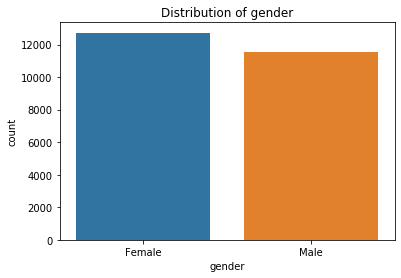

In [34]:
sns.countplot(train_data["gender"]).set_title("Distribution of gender")

Text(0.5, 1.0, 'Gender VS. Target')

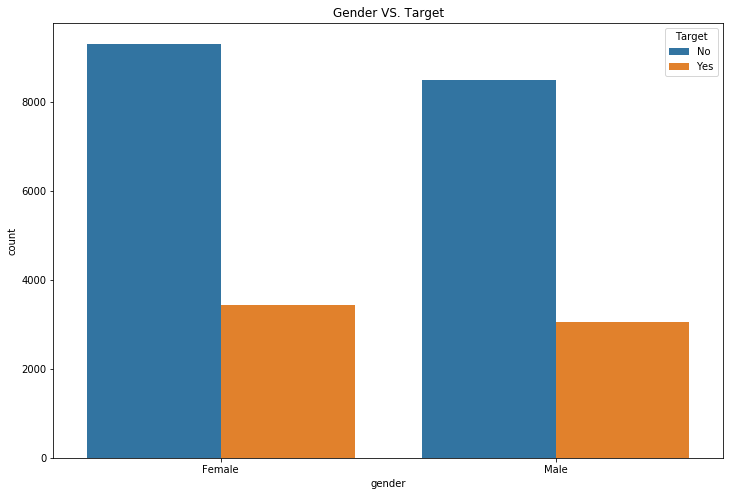

In [35]:
fig = plt.figure(figsize=(12,8))
sns.countplot(x= train_data["gender"], hue = train_data['Target']).set_title('Gender VS. Target')

In [36]:
(train_data["age"].value_counts())/train_data.shape[0] * 100

75.0    24.703166
65.0    22.122361
55.0    17.628628
85.0    15.604387
45.0     9.939809
35.0     4.238127
95.0     2.951847
25.0     1.739776
15.0     0.808047
5.0      0.263852
Name: age, dtype: float64

Text(0.5, 1.0, 'Distribution of Age')

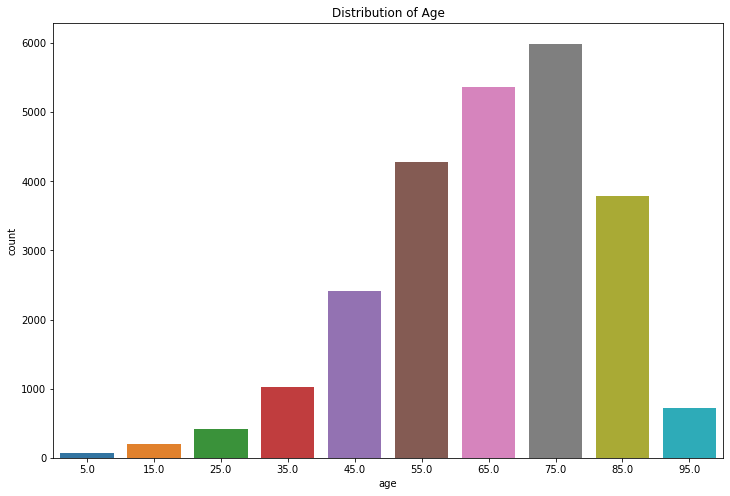

In [37]:
fig = plt.figure(figsize=(12,8))
sns.countplot(train_data["age"]).set_title("Distribution of Age")

Text(0.5, 1.0, 'Age VS. Target')

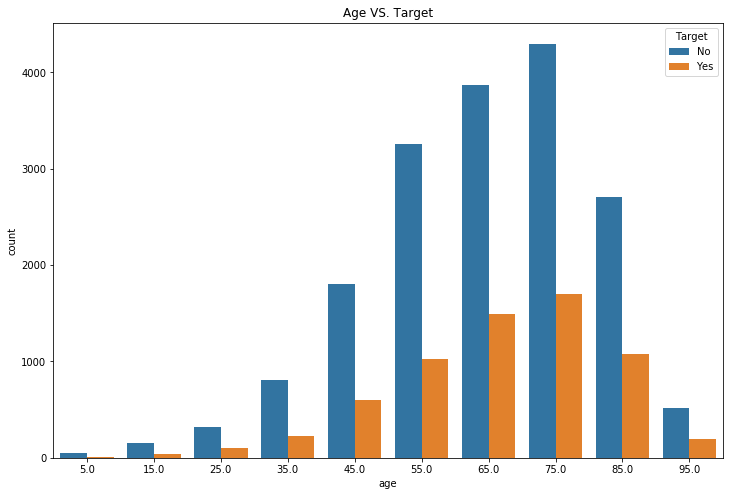

In [38]:
fig = plt.figure(figsize=(12,8))
sns.countplot(x= train_data["age"], hue = train_data['Target']).set_title('Age VS. Target')

#### 24.7% of people sufferening from Diabetes belong to 70-80 age group

In [39]:
(train_data["race"].value_counts())/train_data.shape[0] * 100

type3    74.018799
type1    18.061511
type4     5.433707
type5     1.768635
type2     0.717348
Name: race, dtype: float64

Text(0.5, 1.0, 'Distribution of Race')

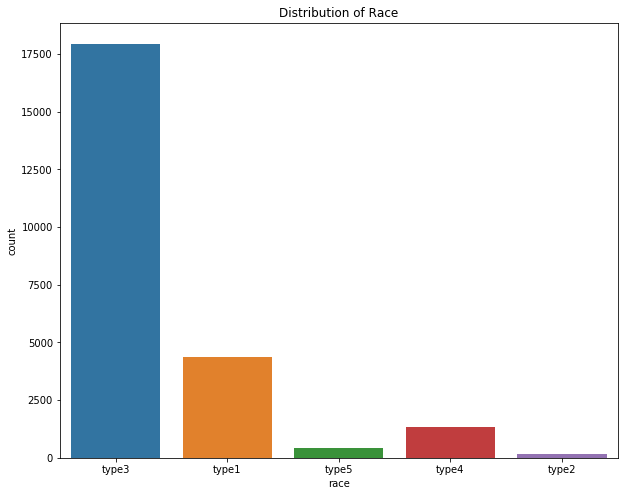

In [40]:
fig = plt.figure(figsize=(10,8))
sns.countplot(train_data["race"]).set_title("Distribution of Race")

Text(0.5, 1.0, 'Race VS. Target')

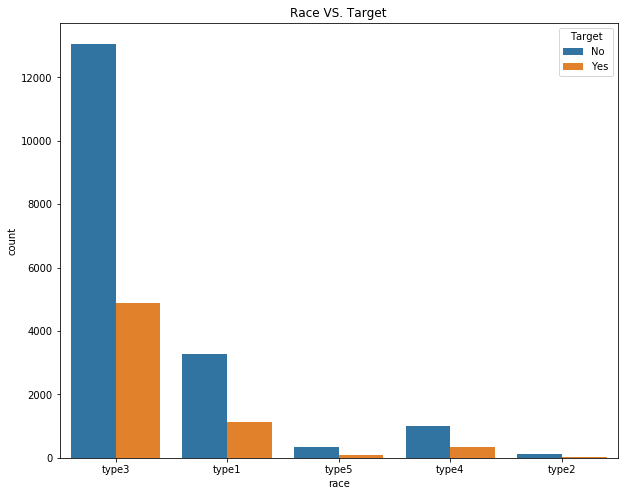

In [41]:
fig = plt.figure(figsize=(10,8))
sns.countplot(x= train_data["race"], hue = train_data['Target']).set_title('Race VS. Target')

#### 74% of the people suffering from Diabetes belong to type3 race

In [42]:
(train_data["Target"].value_counts())/train_data.shape[0] * 100

No     73.326187
Yes    26.673813
Name: Target, dtype: float64

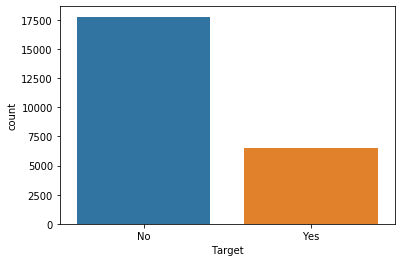

In [43]:
sns.countplot(train_data["Target"])

#### 26% of the total patients are readmitted

In [44]:
(train_data["admission_source_id"].value_counts())/train_data.shape[0] * 100

7     51.467678
1     31.785950
17     6.460257
4      4.262863
6      3.166227
2      1.422328
5      0.820416
9      0.193766
3      0.189644
20     0.185521
10     0.012368
8      0.012368
22     0.008245
14     0.004123
13     0.004123
25     0.004123
Name: admission_source_id, dtype: float64

Text(0.5, 1.0, 'Distribution of Admission Source')

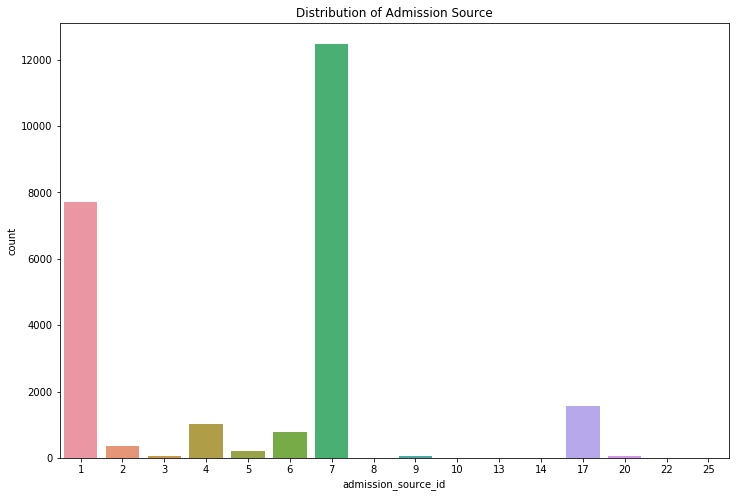

In [45]:
fig = plt.figure(figsize=(12,8))
sns.countplot(train_data["admission_source_id"]).set_title('Distribution of Admission Source')

Text(0.5, 1.0, 'Admission Source VS. Target')

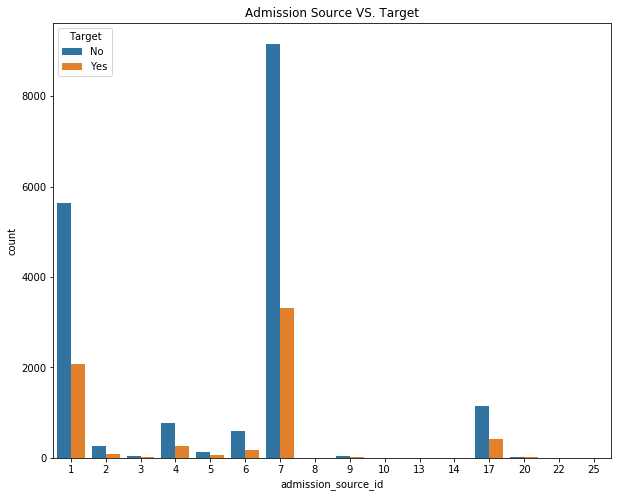

In [46]:
fig = plt.figure(figsize=(10,8))
sns.countplot(x= train_data["admission_source_id"], hue = train_data['Target']).set_title('Admission Source VS. Target')

#### 82% of the patients are admitted through operational sections 7 and 1
#### According to the above values, we can group source_ids (4,2) into group_1, (6,5,9,3,20,10,8,22,14,13,25) into group_2

In [47]:
(train_data["admission_type_id"].value_counts())/train_data.shape[0] * 100

1    50.441128
3    20.605211
2    18.399571
6     5.516161
5     4.497856
8     0.482355
7     0.045350
4     0.012368
Name: admission_type_id, dtype: float64

Text(0.5, 1.0, 'Distribution of Admission Type')

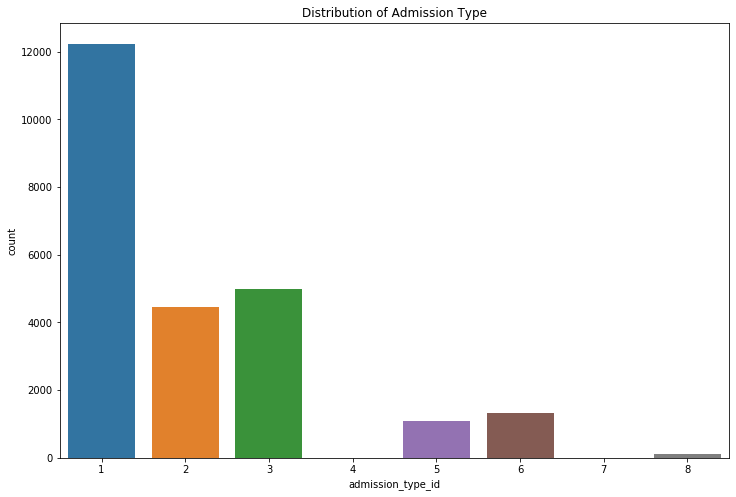

In [48]:
fig = plt.figure(figsize=(12,8))
sns.countplot(train_data["admission_type_id"]).set_title('Distribution of Admission Type')

#### >50% patients are admitted through type 1

Text(0.5, 1.0, 'Admission Month VS. Target')

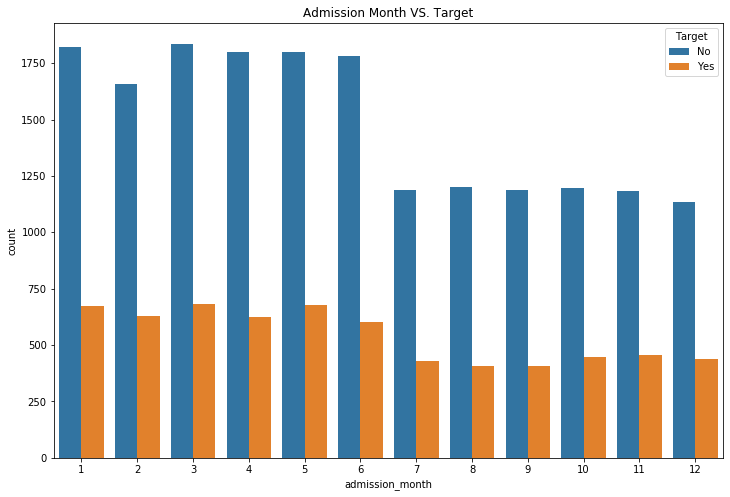

In [49]:
fig = plt.figure(figsize=(12,8))
sns.countplot(x= train_data["admission_month"], hue = train_data['Target']).set_title('Admission Month VS. Target')

Text(0.5, 1.0, 'Admission Month VS. Target')

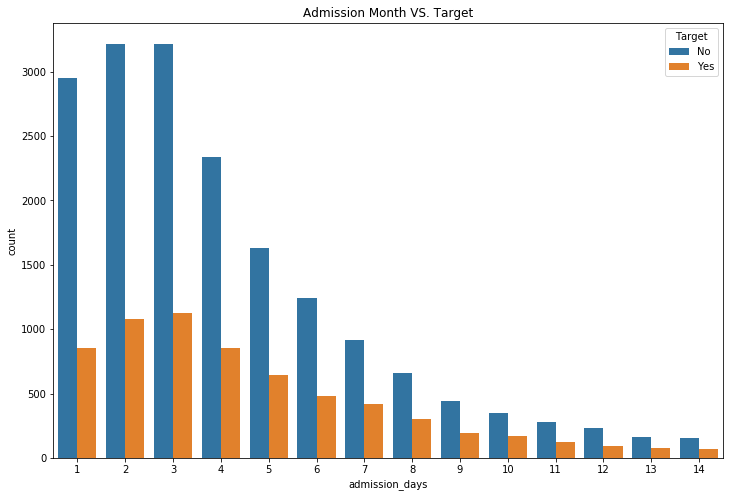

In [50]:
fig = plt.figure(figsize=(12,8))
sns.countplot(x= train_data["admission_days"], hue = train_data['Target']).set_title('Admission Month VS. Target')

Text(0.5, 1.0, 'Change in Patient Treatment VS. Target')

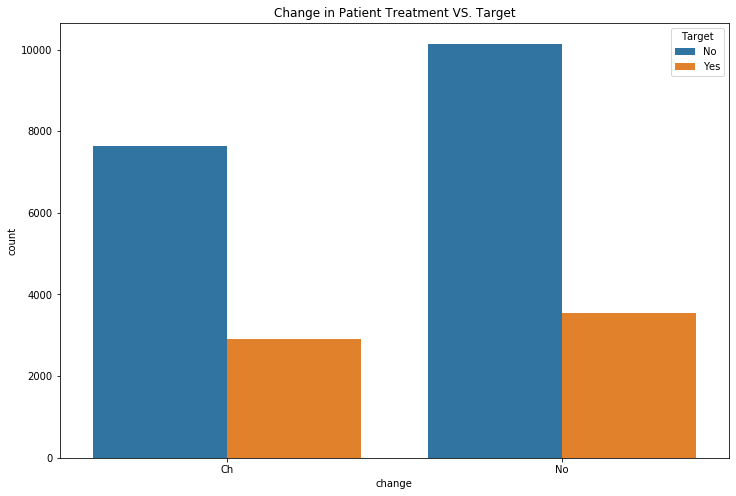

In [51]:
fig = plt.figure(figsize=(12,8))
sns.countplot(x= train_data["change"], hue = train_data['Target']).set_title('Change in Patient Treatment VS. Target')

Text(0.5, 1.0, 'Number of medications VS. Target')

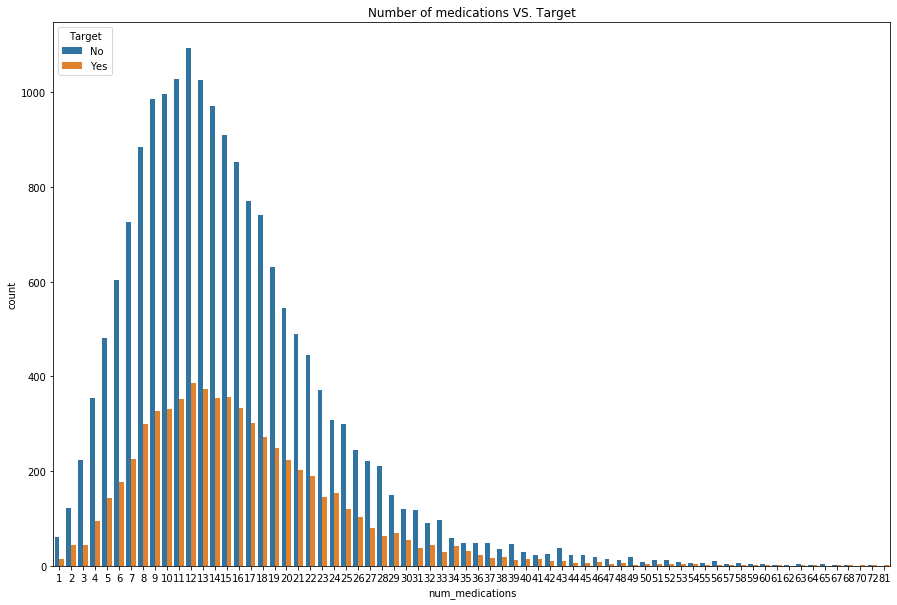

In [52]:
fig = plt.figure(figsize=(15,10))
sns.countplot(x= train_data["num_medications"], hue = train_data['Target']).set_title('Number of medications VS. Target')

Text(0.5, 1.0, 'A1Cresult VS. Target')

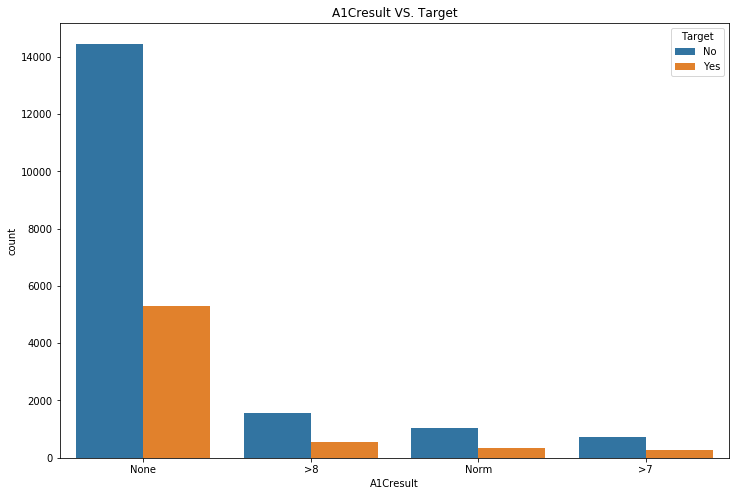

In [53]:
fig = plt.figure(figsize=(12,8))
sns.countplot(x= train_data["A1Cresult"], hue = train_data['Target']).set_title('A1Cresult VS. Target')

Text(0.5, 1.0, 'A1Cresult VS. Target')

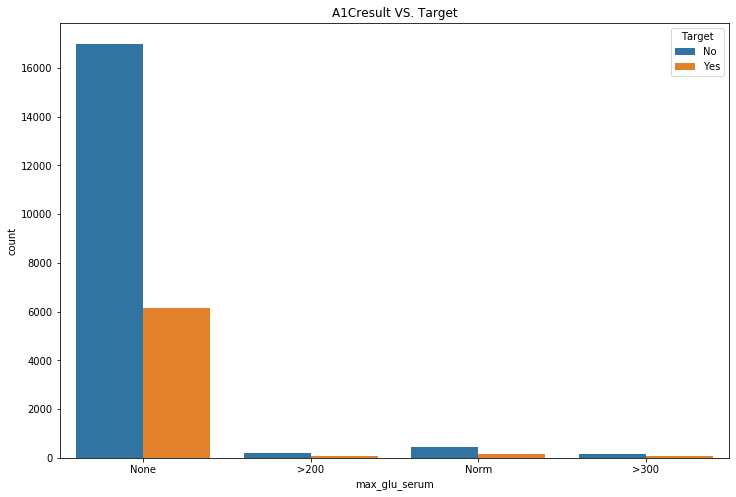

In [54]:
fig = plt.figure(figsize=(12,8))
sns.countplot(x= train_data["max_glu_serum"], hue = train_data['Target']).set_title('A1Cresult VS. Target')

#### Feature Engineering

In [55]:
train_data["max_glu_serum"] = train_data["max_glu_serum"].replace("None",-1)
train_data["max_glu_serum"] = train_data["max_glu_serum"].replace(">200",1)
train_data["max_glu_serum"] = train_data["max_glu_serum"].replace(">300",1)
train_data["max_glu_serum"] = train_data["max_glu_serum"].replace("Norm",0)

train_data["A1Cresult"] = train_data["A1Cresult"].replace("None",-1)
train_data["A1Cresult"] = train_data["A1Cresult"].replace(">8",1)
train_data["A1Cresult"] = train_data["A1Cresult"].replace(">7",1)
train_data["A1Cresult"] = train_data["A1Cresult"].replace("Norm",0)

test_data["max_glu_serum"] = test_data["max_glu_serum"].replace("None",-1)
test_data["max_glu_serum"] = test_data["max_glu_serum"].replace(">200",1)
test_data["max_glu_serum"] = test_data["max_glu_serum"].replace(">300",1)
test_data["max_glu_serum"] = test_data["max_glu_serum"].replace("Norm",0)

test_data["A1Cresult"] = test_data["A1Cresult"].replace("None",-1)
test_data["A1Cresult"] = test_data["A1Cresult"].replace(">8",1)
test_data["A1Cresult"] = test_data["A1Cresult"].replace(">7",1)
test_data["A1Cresult"] = test_data["A1Cresult"].replace("Norm",0)

In [56]:
train_data.head()

,patientID,num_procedures,num_medications,num_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide.metformin,glipizide.metformin,metformin.pioglitazone,change,diabetesMed,admission_type_id,admission_source_id,race,gender,age,Target,admission_days,admission_month
0,PT456611,0,11,9,-1,-1,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,Steady,No,No,No,Ch,Yes,1,1,type3,Female,95.0,No,3,5
1,PT956824,1,6,6,-1,-1,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,1,7,type1,Male,55.0,Yes,3,2
2,PT453330,2,27,9,-1,-1,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,1,7,type3,Female,85.0,No,3,6
3,PT677563,3,10,5,-1,-1,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,Yes,2,1,type3,Female,55.0,No,2,12
4,PT102924,6,12,9,-1,-1,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,3,1,type3,Male,65.0,Yes,1,8


In [57]:
med_columns = ["metformin", "repaglinide", "nateglinide",
       "chlorpropamide", "glimepiride", "glipizide",
       "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose",
       "miglitol", "troglitazone", "tolazamide", "insulin",
       "glyburide.metformin", "glipizide.metformin","metformin.pioglitazone"]

#train_data["gender"] = train_data["gender"].replace("Male", 1)
#train_data["gender"] = train_data["gender"].replace("Female", 0)
train_data["change"] = train_data["change"].replace("Ch", 1)
train_data["change"] = train_data["change"].replace("No", 0)
train_data["diabetesMed"] = train_data["diabetesMed"].replace("Yes", 1)
train_data["diabetesMed"] = train_data["diabetesMed"].replace("No", 0)

train_data["Target"] = train_data["Target"].replace("Yes", 1)
train_data["Target"] = train_data["Target"].replace("No", 0)

for column in med_columns:
    train_data[column] = train_data[column].replace("No", 0)
    train_data[column] = train_data[column].replace("Steady", 1)
    train_data[column] = train_data[column].replace("Up", 1)
    train_data[column] = train_data[column].replace("Down", 1)
    
dummies = pd.get_dummies(train_data["race"],prefix="race")
train_data = pd.concat([train_data,dummies],axis=1)

dummies = pd.get_dummies(train_data["gender"],prefix="gender")
train_data = pd.concat([train_data,dummies],axis=1)


test_data["change"] = test_data["change"].replace("Ch", 1)
test_data["change"] = test_data["change"].replace("No", 0)
test_data["diabetesMed"] = test_data["diabetesMed"].replace("Yes", 1)
test_data["diabetesMed"] = test_data["diabetesMed"].replace("No", 0)

# test_data["Target"] = test_data["Target"].replace("Yes", 1)
# test_data["Target"] = test_data["Target"].replace("No", 0)

for column in med_columns:
    test_data[column] = test_data[column].replace("No", 0)
    test_data[column] = test_data[column].replace("Steady", 1)
    test_data[column] = test_data[column].replace("Up", 1)
    test_data[column] = test_data[column].replace("Down", 1)
    
dummies = pd.get_dummies(test_data["race"],prefix="race")
test_data = pd.concat([test_data,dummies],axis=1)

dummies = pd.get_dummies(test_data["gender"],prefix="gender")
test_data = pd.concat([test_data,dummies],axis=1)

In [58]:
admission_source_group_1 = [4,2]
admission_source_group_2 = [6,5,9,3,20,10,8,22,14,13,25]
admission_source_group_3 = [7]
admission_source_group_4 = [17]
admission_source_group_5 = [1]

train_data["admission_source_group_1"] = np.where(train_data["admission_source_id"].isin(admission_source_group_1),1,0)
train_data["admission_source_group_2"] = np.where(train_data["admission_source_id"].isin(admission_source_group_2),1,0)
train_data["admission_source_group_3"] = np.where(train_data["admission_source_id"].isin(admission_source_group_3),1,0)
train_data["admission_source_group_4"] = np.where(train_data["admission_source_id"].isin(admission_source_group_4),1,0)
train_data["admission_source_group_5"] = np.where(train_data["admission_source_id"].isin(admission_source_group_5),1,0)

test_data["admission_source_group_1"] = np.where(test_data["admission_source_id"].isin(admission_source_group_1),1,0)
test_data["admission_source_group_2"] = np.where(test_data["admission_source_id"].isin(admission_source_group_2),1,0)
test_data["admission_source_group_3"] = np.where(test_data["admission_source_id"].isin(admission_source_group_3),1,0)
test_data["admission_source_group_4"] = np.where(test_data["admission_source_id"].isin(admission_source_group_4),1,0)
test_data["admission_source_group_5"] = np.where(test_data["admission_source_id"].isin(admission_source_group_5),1,0)

In [59]:
admission_type_group_1 = [1]
admission_type_group_2 = [2]
admission_type_group_3 = [3]
admission_type_group_4 = [6]
admission_type_group_5 = [4,5,7,8]

train_data["admission_type_group_1"] = np.where(train_data["admission_type_id"].isin(admission_type_group_1),1,0)
train_data["admission_type_group_2"] = np.where(train_data["admission_type_id"].isin(admission_type_group_2),1,0)
train_data["admission_type_group_3"] = np.where(train_data["admission_type_id"].isin(admission_type_group_3),1,0)
train_data["admission_type_group_4"] = np.where(train_data["admission_type_id"].isin(admission_type_group_4),1,0)
train_data["admission_type_group_5"] = np.where(train_data["admission_type_id"].isin(admission_type_group_5),1,0)

test_data["admission_type_group_1"] = np.where(test_data["admission_type_id"].isin(admission_type_group_1),1,0)
test_data["admission_type_group_2"] = np.where(test_data["admission_type_id"].isin(admission_type_group_2),1,0)
test_data["admission_type_group_3"] = np.where(test_data["admission_type_id"].isin(admission_type_group_3),1,0)
test_data["admission_type_group_4"] = np.where(test_data["admission_type_id"].isin(admission_type_group_4),1,0)
test_data["admission_type_group_5"] = np.where(test_data["admission_type_id"].isin(admission_type_group_5),1,0)

In [60]:
train_data.head()

,patientID,num_procedures,num_medications,num_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide.metformin,glipizide.metformin,metformin.pioglitazone,change,diabetesMed,admission_type_id,admission_source_id,race,gender,age,Target,admission_days,admission_month,race_type1,race_type2,race_type3,race_type4,race_type5,gender_Female,gender_Male,admission_source_group_1,admission_source_group_2,admission_source_group_3,admission_source_group_4,admission_source_group_5,admission_type_group_1,admission_type_group_2,admission_type_group_3,admission_type_group_4,admission_type_group_5
0,PT456611,0,11,9,-1,-1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,1,1,type3,Female,95.0,0,3,5,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0
1,PT956824,1,6,6,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,type1,Male,55.0,1,3,2,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0
2,PT453330,2,27,9,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,type3,Female,85.0,0,3,6,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0
3,PT677563,3,10,5,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,2,1,type3,Female,55.0,0,2,12,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0
4,PT102924,6,12,9,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,type3,Male,65.0,1,1,8,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0


In [61]:
train_data = train_data.drop(["admission_type_id","admission_source_id","race","gender"],axis=1)
test_data = test_data.drop(["admission_type_id","admission_source_id","race","gender"],axis=1)

In [62]:
train_data.columns

Index(['patientID', 'num_procedures', 'num_medications', 'num_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
       'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol',
       'troglitazone', 'tolazamide', 'insulin', 'glyburide.metformin',
       'glipizide.metformin', 'metformin.pioglitazone', 'change',
       'diabetesMed', 'age', 'Target', 'admission_days', 'admission_month',
       'race_type1', 'race_type2', 'race_type3', 'race_type4', 'race_type5',
       'gender_Female', 'gender_Male', 'admission_source_group_1',
       'admission_source_group_2', 'admission_source_group_3',
       'admission_source_group_4', 'admission_source_group_5',
       'admission_type_group_1', 'admission_type_group_2',
       'admission_type_group_3', 'admission_type_group_4',
       'admission_type_group_5'],
      dtype='object')

In [63]:
features = ['num_procedures', 'num_medications', 'num_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
       'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol',
       'troglitazone', 'tolazamide', 'insulin', 'glyburide.metformin',
       'glipizide.metformin', 'metformin.pioglitazone', 'change',
       'diabetesMed', 'age', 'admission_days', 'admission_month',
       'race_type1', 'race_type2', 'race_type3', 'race_type4', 'race_type5',
       'gender_Female', 'gender_Male', 'admission_source_group_1',
       'admission_source_group_2', 'admission_source_group_3',
       'admission_source_group_4', 'admission_source_group_5',
       'admission_type_group_1', 'admission_type_group_2',
       'admission_type_group_3', 'admission_type_group_4',
       'admission_type_group_5']

target = ['Target']

## Model building 

#### Logistic Regression 

In [64]:
X_train, X_test, Y_train, Y_test = train_test_split(train_data[features],train_data[target],test_size=0.3)
logit = LogisticRegression(fit_intercept=True, penalty='l1')
logit.fit(X_train, Y_train)

C:\Users\mounika.rudra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mounika.rudra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [65]:
logit_pred = logit.predict(X_train)

print("Accuracy is {0:.2f}".format(accuracy_score(Y_train, logit_pred)))
print("Precision is {0:.2f}".format(precision_score(Y_train, logit_pred)))
print("Recall is {0:.2f}".format(recall_score(Y_train, logit_pred)))

Accuracy is 0.73
Precision is 0.00
Recall is 0.00


C:\Users\mounika.rudra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [66]:
logit_pred = logit.predict(X_test)

print("Accuracy is {0:.2f}".format(accuracy_score(Y_test, logit_pred)))
print("Precision is {0:.2f}".format(precision_score(Y_test, logit_pred)))
print("Recall is {0:.2f}".format(recall_score(Y_test, logit_pred)))

Accuracy is 0.74
Precision is 0.00
Recall is 0.00


C:\Users\mounika.rudra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Handling imbalanced data

In [67]:
print('Original dataset shape {}'.format(Counter(Y_train)))
sm = SMOTE(random_state=20)
#train_input_new, train_output_new = sm.fit_sample(X_train,Y_train)
train_input_new, train_output_new = sm.fit_sample(train_data[features],train_data[target])
print('New dataset shape {}'.format(Counter(train_output_new)))
X_train, X_test, Y_train, Y_test = train_test_split(train_input_new, train_output_new, test_size=0.20, random_state=0)

Original dataset shape Counter({'Target': 1})


C:\Users\mounika.rudra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


New dataset shape Counter({0: 17786, 1: 17786})


In [68]:
def evaluate(Y_test,Y_pred):
    print("Accuracy is {0:.2f}".format(accuracy_score(Y_test, Y_pred)))
    print("Precision is {0:.2f}".format(precision_score(Y_test, Y_pred)))
    print("Recall is {0:.2f}".format(recall_score(Y_test, Y_pred)))
    print("F1 score is {0:.2f}".format(f1_score(Y_test, Y_pred)))

#### K-NN

In [69]:
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [70]:
knn = KNeighborsClassifier(n_neighbors=5, weights="uniform")#metric='euclidean',
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)

In [71]:
confusion_matrix(Y_test, y_pred)

array([[1718, 1856],
       [ 438, 3103]], dtype=int64)

In [72]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean',weights="uniform")
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)
evaluate(Y_test,y_pred) #metric='euclidean',weights="uniform"

Accuracy is 0.68
Precision is 0.63
Recall is 0.88
F1 score is 0.73


In [73]:
knn = KNeighborsClassifier(n_neighbors=5, weights="uniform")
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)
evaluate(Y_test,y_pred)

Accuracy is 0.68
Precision is 0.63
Recall is 0.88
F1 score is 0.73


In [74]:
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")#metric='euclidean',
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)
evaluate(Y_test,y_pred) #metric='euclidean',weights="distance"

Accuracy is 0.71
Precision is 0.64
Recall is 0.93
F1 score is 0.76


In [75]:
y_pred_test = knn.predict(test_data[features])

In [76]:
def label_encode(df):
    if df.Target == "No":
        return 0
    else:
        return 1

y_test = test_data[target].apply(label_encode, axis=1)

In [77]:
evaluate(y_test,y_pred_test)

Accuracy is 0.34
Precision is 1.00
Recall is 0.34
F1 score is 0.50


#### Decision tree

In [78]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
dtree.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=28,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [79]:
dtree_pred = dtree.predict(X_test)
print("Accuracy is {0:.2f}".format(accuracy_score(Y_test, dtree_pred)))
print("Precision is {0:.2f}".format(precision_score(Y_test, dtree_pred)))
print("Recall is {0:.2f}".format(recall_score(Y_test, dtree_pred)))

Accuracy is 0.73
Precision is 0.74
Recall is 0.72


In [80]:
dtree_pred = dtree.predict(test_data[features])
evaluate(y_test,dtree_pred)

Accuracy is 0.24
Precision is 1.00
Recall is 0.24
F1 score is 0.39


#### Random Forest

In [81]:
from sklearn.ensemble import RandomForestClassifier

rm = RandomForestClassifier(n_estimators = 100, max_depth=26, criterion = "entropy", min_samples_split=10)
rm.fit(X_train, Y_train)
rm_prd = rm.predict(X_test)

print("Accuracy is {0:.2f}".format(accuracy_score(Y_test, rm_prd)))
print("Precision is {0:.2f}".format(precision_score(Y_test, rm_prd)))
print("Recall is {0:.2f}".format(recall_score(Y_test, rm_prd)))

Accuracy is 0.82
Precision is 0.98
Recall is 0.65


In [82]:
pd.crosstab(pd.Series(Y_test, name = 'Actual'), pd.Series(rm_prd, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,3539,35,3574
1,1253,2288,3541
All,4792,2323,7115


In [83]:
rm_pred = rm.predict(test_data[features])
evaluate(y_test,rm_pred)

Accuracy is 0.08
Precision is 1.00
Recall is 0.08
F1 score is 0.14


In [84]:
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(rm_pred, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
1,6696,561,7257
All,6696,561,7257


#### Importanf Features from Random Forest 

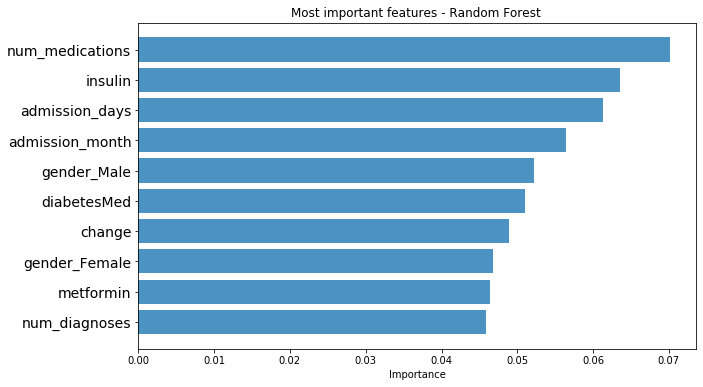

In [85]:
feature_names = features
feature_imports = rm.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest ')
plt.show()

#### Gradient Boosting

In [86]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

#svc=SVC(probability=True, kernel='linear',cache_size=9000)

#clf = AdaBoostClassifier(n_estimators=100,base_estimator=svc)
# for i in range(1,10):
clf = GradientBoostingClassifier(loss="exponential",n_estimators=100,max_depth=6)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

print("Accuracy is {0:.2f}".format(accuracy_score(Y_test, Y_pred)))
print("Precision is {0:.2f}".format(precision_score(Y_test, Y_pred)))
print("Recall is {0:.2f}".format(recall_score(Y_test, Y_pred)))


Accuracy is 0.82
Precision is 1.00
Recall is 0.65


In [87]:
type(X_test)

numpy.ndarray

In [88]:
pd.crosstab(pd.Series(Y_test, name = 'Actual'), pd.Series(Y_pred, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,3566,8,3574
1,1253,2288,3541
All,4819,2296,7115


#### Cross Validation

In [89]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_test, Y_test, cv=5)
scores

array([0.81039326, 0.84399157, 0.80955727, 0.78636683, 0.80942335])

#### Prediction of values on test_data 

In [90]:
Y_pred = clf.predict(test_data[features].values)

In [91]:
test_data["Target"] = pd.Series(Y_pred)
test_data["Target"] = test_data["Target"].replace(1,"Yes")
test_data["Target"] = test_data["Target"].replace(0,"No")
final_data = test_data[["patientID","Target"]]
final_data.head()

,patientID,Target
0,PT456611,No
1,PT956824,No
2,PT453330,No
3,PT677563,No
4,PT102924,No
